In [2]:
import gym
from gym.spaces.utils import flatdim
import numpy as np
import matplotlib.pyplot as plt
# from tqdm import trange
from tqdm.auto import tqdm  # notebook compatible
from minigrid.envs import FourRoomsEnv
import matplotlib.pyplot as plt
import graphviz
from copy import deepcopy
from collections import defaultdict

/home/luke/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
class FrozenLakeModel:
    def __init__(self, transitions):
        self.model = transitions

    def step(self, obs, action):
        _, next_obs, r, done =  self.model[obs][action][0]
        return next_obs, r, done, _
    
    def actions(self, obs):
        return list(self.model[obs].keys())

class Node:
    def __init__(self, state, action=None):
        self.state = state
        self.action = action
        self.reward = 0
        self.done = False

        self.parent = None
        self.children = {}

        self.value = 0.0
        self.visits = 0
    
    def __repr__(self):
        return f"Node: (s:{self.state}, a:{self.action}, r:{self.reward}, d:{self.done})"
    
    def update_stats(self, val):
        self.visits += 1
        self.value += (val - self.value) / float(self.visits)

class MCTS:
    def __init__(self, cur_state, model, hparams):
        self.cur_state = cur_state
        self.model = model
        self.iters: int = hparams["iters"]
        self.discount = hparams.get("discount", 0.99) 
        self.sim_depth = hparams.get("sim_depth", 1000)
        self.rollout_heuristic = hparams.get("rollout_heuristic", None)
        self.expansion_heuristic = hparams.get("expansion_heuristic", None)
        self.dupes: dict[tuple, Node] = {}
    
    def search(self):
        root = Node(self.cur_state)
        print("Running MCTS.")
        pbar = tqdm(range(self.iters))
        for i in pbar:
            next_node = self._treePolicy(root)
            reward = self._rolloutPolicy(next_node)
            self._backup(next_node, reward)

            pbar.set_description(f"Action Values: {[child.value for child in root.children.values()]}")
        
        print("MCTS finished.")
        return self._best_action(root), root

    # "Most Robust Child" selection: http://www.incompleteideas.net/609%20dropbox/other%20readings%20and%20resources/MCTS-survey.pdf
    def _best_action(self, root):
        return max(root.children.values(), key = lambda child: child.visits).action

    # Tree Policy explores current tree up to edge.
    def _treePolicy(self, cur_node) -> Node:

        next_node = cur_node
        while not next_node.done:
            if not self._expanded(next_node):
                return self._expand(next_node)
            else:
                next_node = self._UCT(next_node)

        return next_node

    # Rollout policy performs random (or via some policy) rollouts til termination. Returns reward.
    def _rolloutPolicy(self, node: Node) -> float:
        
        cur_node = node
        done = False
        cum_reward = node.reward
        for _ in range(self.sim_depth):
            if self.rollout_heuristic is not None:
                action = np.random.choice(self.model.actions(cur_node.state), p=self.heuristic)
            else:
                action = np.random.choice(self.model.actions(cur_node.state))

            next_obs, r, done, _ = self.model.step(cur_node.state, action) 

            cum_reward += r
            if done:
                break
                
            cur_node = Node(next_obs)
        return cum_reward

    def _UCT(self, node: Node) -> Node:
        children: list[Node] = list(node.children.values())
        weights = [child.value + 1.5 * np.sqrt(np.log(node.visits + 1e-6) / (child.visits + 1e-6)) for child in children]
        weights = np.array(weights) / sum(weights)
        return np.random.choice(children, p=weights)

    def _expanded(self, node: Node) -> bool:
        return set(self.model.actions(node.state)) == set(node.children.keys())

    def _expand(self, node: Node) -> Node:

        # Sample random action
        actions = self.model.actions(node.state)
        if (len(node.children.keys()) > 0):
            for performed in list(node.children.keys()):
                actions.remove(performed)

        if(self.expansion_heuristic is not None):
            available_probs = self.expansion_heuristic[actions]
            normalize = sum(self.expansion_heuristic[actions])
            modified_probs = available_probs/normalize if normalize > 0 else np.ones_like(available_probs) / sum(np.ones_like(available_probs))
            action = np.random.choice(actions, p=modified_probs)
        else: 
            action = np.random.choice(actions)

        next_obs, r, done, _ = self.model.step(node.state, action)

        # if next_obs in self.dupes:
        #     return self.dupes[next_obs]

        # Construct new node
        next_node = Node(next_obs, action)
        next_node.parent = node
        next_node.reward = r
        next_node.done = done

        # Add to list of children
        node.children[action] = next_node
        self.dupes[next_obs] = next_node

        return next_node



    def _backup(self, node: Node, reward: float) -> None:
        node.update_stats(reward)

        while node.parent:
            node = node.parent
            node.update_stats(self.discount * reward)

# For viz purposes
def unpack(root: Node, graph, ignore, action_map=None):
    if (not root.parent):
        graph.node(str(root.state))

    if len(root.children.values()) == 0:
        return graph
    
    for child in root.children.values():
        if (not (str(root.state), str(child.state), child.action) in ignore):
            graph.edge(str(root.state), str(child.state), label=str(child.action if not action_map else action_map[child.action]))
            ignore.add((str(root.state), str(child.state), child.action))

        graph = unpack(child, graph, ignore, action_map=action_map)
    
    return graph

# Visualize visitation frequency
def unpack_visits(root: Node, visit_freqs=defaultdict(lambda: 0)):
    if len(root.children.values()) == 0:
        visit_freqs[root.state] += root.visits
    
    for child in root.children.values():
        visit_freqs = unpack_visits(child, visit_freqs)
    
    return visit_freqs

In [50]:
env = gym.make("FrozenLake-v1", is_slippery=False)
model = FrozenLakeModel(env.P)
obs = env.reset()

action_map = {
    0: "LEFT",
    1: "DOWN", 
    2: "RIGHT",
    3: "UP"
}

obs = env.reset()
done = False
ep_r = 0
while not done:
    action, values = MCTS(obs, model, {"iters": 1000}).search()
    # print([(action_map[child.action], child.value) for child in values.children.values()])
    # print(f"Moving {action_map[action]}")
    obs, r, done, _ = env.step(action)
    ep_r += r

print(f"Episode return: {ep_r}")

Running MCTS.


Action Values: [0.007586206896551722, 0.01948818897637794, 0.020286885245901633, 0.016431535269709543]: 100%|██████████| 1000/1000 [00:01<00:00, 503.94it/s] 


MCTS finished.
Running MCTS.


Action Values: [0.0, 0.02302325581395349, 0.011556420233463031, 0.00767441860465116]: 100%|██████████| 1000/1000 [00:01<00:00, 548.38it/s]  


MCTS finished.
Running MCTS.


Action Values: [0.0, 0.01889312977099235, 0.011927710843373485, 0.01603238866396761]: 100%|██████████| 1000/1000 [00:01<00:00, 563.30it/s]  


MCTS finished.
Running MCTS.


Action Values: [0.004267241379310343, 0.008048780487804877, 0.01577689243027888, 0.02922509225092251]: 100%|██████████| 1000/1000 [00:01<00:00, 528.59it/s]  


MCTS finished.
Running MCTS.


Action Values: [0.0, 0.02686046511627906, 0.07043478260869564, 0.015408560311284042]: 100%|██████████| 1000/1000 [00:01<00:00, 550.18it/s] 


MCTS finished.
Running MCTS.


Action Values: [0.0, 0.019038461538461535, 0.015468749999999995, 0.01146718146718147]: 100%|██████████| 1000/1000 [00:01<00:00, 525.49it/s] 


MCTS finished.
Running MCTS.


Action Values: [0.01685106382978723, 0.025666666666666667, 0.0, 0.011879999999999998]: 100%|██████████| 1000/1000 [00:01<00:00, 594.82it/s]


MCTS finished.
Running MCTS.


Action Values: [0.0, 0.016431535269709547, 0.026450381679389297, 0.01941176470588234]: 100%|██████████| 1000/1000 [00:01<00:00, 598.08it/s]


MCTS finished.
Running MCTS.


Action Values: [0.0, 0.015468750000000002, 0.0, 0.015000000000000008]: 100%|██████████| 1000/1000 [00:01<00:00, 626.78it/s]


MCTS finished.
Running MCTS.


Action Values: [0.008319327731092436, 0.026150943396226416, 0.00825, 0.019260700389105056]: 100%|██████████| 1000/1000 [00:01<00:00, 523.25it/s]             


MCTS finished.
Running MCTS.


Action Values: [0.0, 0.01523076923076923, 0.012172131147540989, 0.023023255813953487]: 100%|██████████| 1000/1000 [00:01<00:00, 589.19it/s] 


MCTS finished.
Running MCTS.


Action Values: [0.008148148148148146, 0.0, 0.008081632653061223, 0.032637362637362624]: 100%|██████████| 1000/1000 [00:01<00:00, 560.53it/s]


MCTS finished.
Running MCTS.


Action Values: [0.011785714285714274, 0.018749999999999992, 0.0, 0.048888888888888864]: 100%|██████████| 1000/1000 [00:01<00:00, 507.46it/s]


MCTS finished.
Running MCTS.


Action Values: [0.0, 0.004342105263157892, 0.019335937499999997, 0.007415730337078651]: 100%|██████████| 1000/1000 [00:01<00:00, 554.63it/s] 


MCTS finished.
Running MCTS.


Action Values: [0.007764705882352938, 0.004040816326530612, 0.020886075949367082, 0.015057034220532317]: 100%|██████████| 1000/1000 [00:01<00:00, 537.70it/s]


MCTS finished.
Running MCTS.


Action Values: [0.02267175572519084, 0.025169491525423724, 0.0, 0.03549800796812749]: 100%|██████████| 1000/1000 [00:01<00:00, 593.17it/s] 


MCTS finished.
Running MCTS.


Action Values: [0.016363636363636358, 0.004177215189873418, 0.018265682656826553, 0.019799999999999995]: 100%|██████████| 1000/1000 [00:01<00:00, 543.09it/s]


MCTS finished.
Running MCTS.


Action Values: [0.015172413793103443, 0.0, 0.015903614457831325, 0.00818181818181818]: 100%|██████████| 1000/1000 [00:01<00:00, 603.11it/s] 


MCTS finished.
Running MCTS.


Action Values: [0.007704280155642021, 0.007471698113207545, 0.008389830508474576, 0.024545454545454554]: 100%|██████████| 1000/1000 [00:01<00:00, 510.84it/s]


MCTS finished.
Running MCTS.


Action Values: [0.00818181818181818, 0.012323651452282147, 0.003735849056603773, 0.011785714285714285]: 100%|██████████| 1000/1000 [00:01<00:00, 548.47it/s] 


MCTS finished.
Running MCTS.


Action Values: [0.012638297872340427, 0.012272727272727268, 0.022846153846153832, 0.011292775665399228]: 100%|██████████| 1000/1000 [00:01<00:00, 509.03it/s]


MCTS finished.
Running MCTS.


Action Values: [0.016229508196721316, 0.01584, 0.011556420233463023, 0.015903614457831318]: 100%|██████████| 1000/1000 [00:01<00:00, 509.47it/s]            


MCTS finished.
Running MCTS.


Action Values: [0.008534482758620688, 0.00776470588235294, 0.00792, 0.0]: 100%|██████████| 1000/1000 [00:01<00:00, 571.00it/s]              

MCTS finished.
Episode return: 0.0


Running MCTS.


100%|██████████| 5000/5000 [00:01<00:00, 3188.57it/s]


MCTS finished.


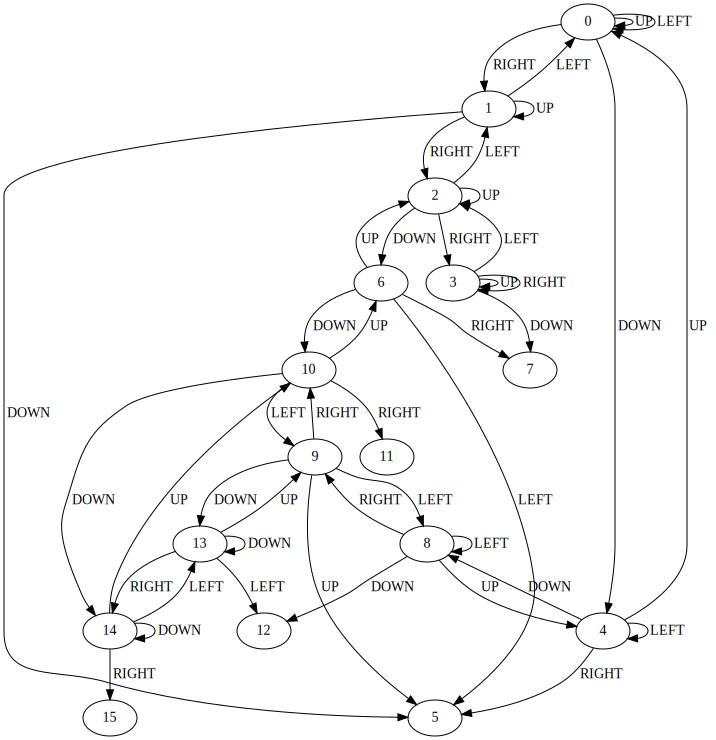

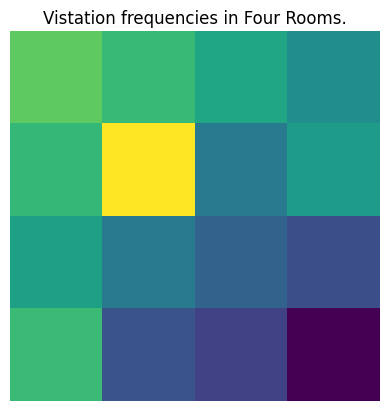

In [8]:
obs = env.reset()
action, root = MCTS(obs, model, {"iters": 5000}).search()
graph = unpack(root, graphviz.Digraph(), set(), action_map=action_map)
graph.render("./frozen-lake/visit-tree", format="png")

freqs = unpack_visits(root)

grid = np.zeros((4, 4))
for l, visits in freqs.items():
    grid[np.unravel_index(l, (4,4))] += visits

grid = np.log(grid)
grid[grid == -np.inf] = 0
plt.imshow(grid)
plt.title("Vistation frequencies in Four Rooms.")
plt.axis("off")
graph

  0%|          | 0/64 [00:00<?, ?it/s]

Running MCTS.


  2%|▏         | 1/64 [00:00<00:08,  7.23it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 1294.15it/s]


MCTS finished.
Running MCTS.


  5%|▍         | 3/64 [00:00<00:05, 11.96it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 1724.64it/s]


MCTS finished.
Running MCTS.


  8%|▊         | 5/64 [00:00<00:04, 12.59it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 924.13it/s]


MCTS finished.
Running MCTS.


 11%|█         | 7/64 [00:00<00:04, 11.54it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 793.47it/s]


MCTS finished.
Running MCTS.


 14%|█▍        | 9/64 [00:00<00:04, 11.14it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 1833.50it/s]


MCTS finished.
Running MCTS.


 17%|█▋        | 11/64 [00:00<00:04, 11.64it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 952.31it/s]


MCTS finished.
Running MCTS.


 20%|██        | 13/64 [00:01<00:04, 11.62it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 794.80it/s]


MCTS finished.
Running MCTS.


 23%|██▎       | 15/64 [00:01<00:04, 11.31it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 1410.43it/s]


MCTS finished.
Running MCTS.


 27%|██▋       | 17/64 [00:01<00:04, 10.88it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 786.79it/s]


MCTS finished.
Running MCTS.


 30%|██▉       | 19/64 [00:01<00:04, 10.29it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 6863.42it/s]


MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 3574.34it/s]


MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 3174.11it/s]


MCTS finished.
Running MCTS.


 36%|███▌      | 23/64 [00:01<00:02, 13.69it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 1919.67it/s]


MCTS finished.
Running MCTS.


 39%|███▉      | 25/64 [00:02<00:02, 13.16it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 1377.01it/s]


MCTS finished.
Running MCTS.


 42%|████▏     | 27/64 [00:02<00:02, 13.40it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 2465.70it/s]


MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 3265.93it/s]


MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 7349.66it/s]


MCTS finished.
Running MCTS.


 48%|████▊     | 31/64 [00:02<00:01, 17.43it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 1508.28it/s]


MCTS finished.
Running MCTS.


 52%|█████▏    | 33/64 [00:02<00:01, 17.34it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 1837.71it/s]


MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 2944.30it/s]


MCTS finished.
Running MCTS.


 56%|█████▋    | 36/64 [00:02<00:01, 19.56it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 3795.30it/s]


MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 2616.21it/s]


MCTS finished.
Running MCTS.


 61%|██████    | 39/64 [00:02<00:01, 20.60it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 1700.94it/s]


MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 2154.95it/s]


MCTS finished.
Running MCTS.


 66%|██████▌   | 42/64 [00:02<00:01, 21.32it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 7304.10it/s]


MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 4647.07it/s]


MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 4062.40it/s]


MCTS finished.
Running MCTS.


 72%|███████▏  | 46/64 [00:02<00:00, 25.48it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 7964.12it/s]


MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 2424.19it/s]


MCTS finished.
Running MCTS.


 77%|███████▋  | 49/64 [00:03<00:00, 26.43it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 7778.47it/s]


MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 4749.90it/s]


MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 3737.34it/s]


MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 7763.35it/s]


MCTS finished.
Running MCTS.


 84%|████████▍ | 54/64 [00:03<00:00, 31.27it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 7722.61it/s]


MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 4085.83it/s]


MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 2295.26it/s]


MCTS finished.
Running MCTS.


 91%|█████████ | 58/64 [00:03<00:00, 31.39it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 4183.51it/s]


MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 7740.57it/s]


MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 6327.11it/s]


MCTS finished.
Running MCTS.


 97%|█████████▋| 62/64 [00:03<00:00, 33.52it/s]

MCTS finished.
Running MCTS.


100%|██████████| 100/100 [00:00<00:00, 5023.36it/s]


MCTS finished.
Running MCTS.


100%|██████████| 64/64 [00:03<00:00, 18.53it/s]
/tmp/ipykernel_1475/617346661.py:10: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(V.reshape(int(np.sqrt(nS)), int(np.sqrt(nS)))))


MCTS finished.


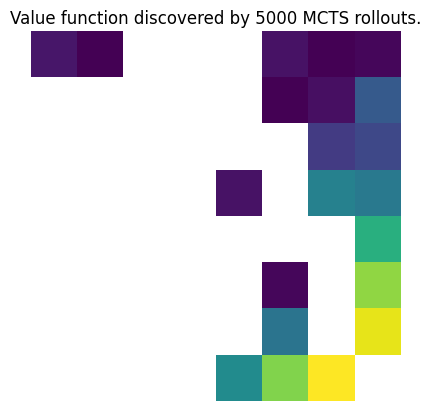

In [9]:
# MCTS estimated values in every state
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
model = FrozenLakeModel(env.P)
nS = flatdim(env.observation_space)
V = np.zeros(nS)
for i in tqdm(range(env.observation_space.n)):
    _, values = MCTS(i, model, {"iters": 100}).search()
    V[i] = np.mean([child.value for child in values.children.values()])

plt.imshow(np.log(V.reshape(int(np.sqrt(nS)), int(np.sqrt(nS)))))
plt.title("Value function discovered by 5000 MCTS rollouts.")
plt.axis("off")
plt.savefig("./frozen-lake/value-5000")

In [60]:
class FourRoomsModel:
    def __init__(self, goal_pos=(16,16), seed=42):
        self.goal_pos = goal_pos
        self.seed = seed

    def step(self, agent_state, action) -> tuple[_, float]:
        agent_pos, agent_dir = agent_state
        env = FourRoomsEnvPos(agent_pos=agent_pos, goal_pos=self.goal_pos)
        env.reset(seed=self.seed)
        env.agent_dir = agent_dir
        return env.step(action)

    def actions(self, obs) -> list[int]:
        return list(range(env.action_space.n - 4))

class FourRoomsEnvPos(FourRoomsEnv):
    def __init__(self, agent_pos=None, goal_pos=None, **kwargs):
        super().__init__(agent_pos=agent_pos, goal_pos=goal_pos, **kwargs)
        self.max_steps = 1000
    
    def step(self, action):
        _, r, terminated, truncated, _ = super().step(action)
        return (self.agent_pos, self.agent_dir), int(self.agent_pos == self._goal_default_pos), terminated or truncated, _

    def reset(self, seed=None):
        obs, _ = super().reset(seed=seed)
        return self.agent_pos, self.agent_dir


action_map = {
    0: "left",
    1: "right",
    2: "forward",
    3: "pickup",
    4: "drop",
    5: "toggle",
    6: "done" 
}

(-0.5, 607.5, 607.5, -0.5)

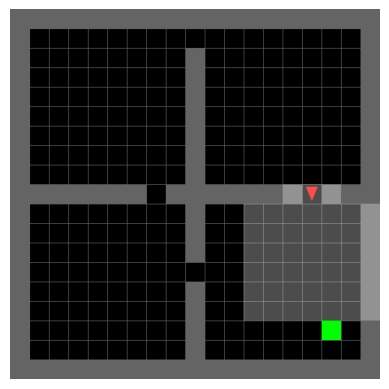

In [61]:
env = FourRoomsEnvPos(agent_pos=(15,9), goal_pos=(16,16))
obs, _ = env.reset(seed=42)
plt.imshow(env.get_frame())
plt.axis("off")
# plt.savefig("./four-rooms/env")

Running MCTS.


Action Values: [0.03, 0.05910447761194028, 0.10358208955223877]: 100%|██████████| 200/200 [00:38<00:00,  5.19it/s]                

MCTS finished.



/tmp/ipykernel_1475/1760543898.py:15: RuntimeWarning: divide by zero encountered in log
  grid = np.log(grid)


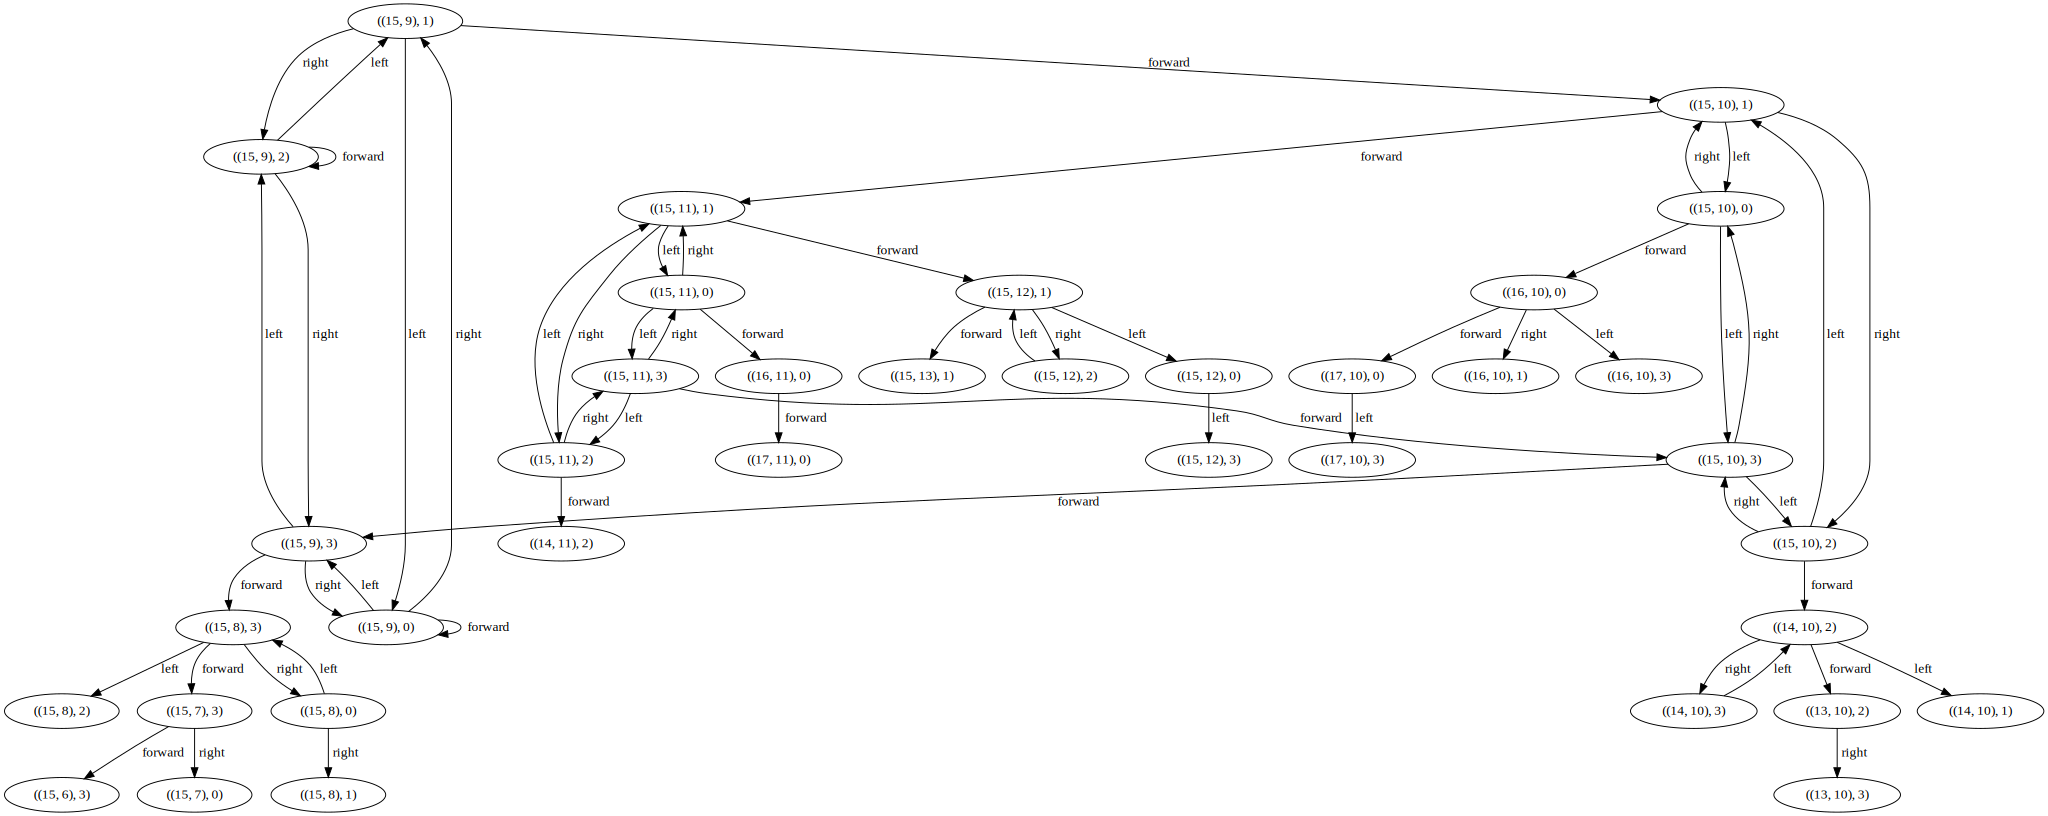

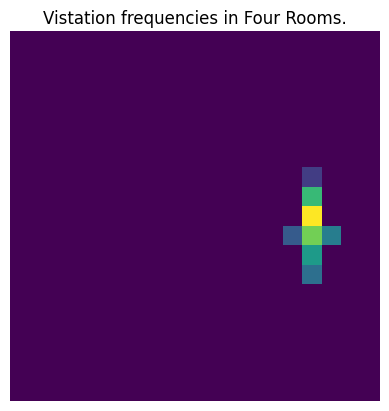

In [63]:
model = FourRoomsModel()
env = FourRoomsEnvPos(agent_pos=(15, 9), goal_pos=(16,16))

obs = env.reset(seed=42)
# mcts = MCTS(obs, model, {"iters": 2000, "sim_depth": 5, "heuristic": [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]})
# action, root = MCTS(obs, model, {"iters": 5000, "sim_depth": 1, "expansion_heuristic": np.array([1/3, 1/3, 1/3, 0, 0, 0, 0])}).search()
action, root = MCTS(obs, model, {"iters": 200, "sim_depth": 80, "discount":0.9}).search()

freqs = unpack_visits(root, visit_freqs=defaultdict(lambda: 0))

grid = np.zeros((19, 19))
for loc, visits in freqs.items():
    grid[loc[0][1], loc[0][0]] += visits

grid = np.log(grid)
grid[grid == -np.inf] = 0
plt.imshow(grid)
plt.title("Vistation frequencies in Four Rooms.")
plt.axis("off")
# plt.savefig("./four-rooms/visits.png")

graph = unpack(root, graphviz.Digraph(), set(), action_map=action_map)
# graph.render()
graph

In [25]:
a = np.array([0, 1, 2, 3, 4])
a[[0, 2, 4]]

array([0, 2, 4])

In [66]:

env = FourRoomsEnvPos(agent_pos=(15, 9), goal_pos=(16,16))
obs = env.reset(seed=42)

done = False
ep_r = 0
while not done:
    action, root = MCTS(obs, FourRoomsModel(), {"iters": 1000, "sim_depth": 20, "discount":0.8}).search()
    
    print(f"Taking action: {action_map[action]}")
    obs, r, done, _ = env.step(action)
    print(f"Current State: {obs}")
    ep_r += r

print(f"Episode return: {ep_r}")


Running MCTS.


Action Values: [0.003278145695364239, 0.02516949152542371, 0.005755813953488372]: 100%|██████████| 1000/1000 [00:52<00:00, 19.21it/s]  


MCTS finished.
Taking action: forward
Current State: ((15, 10), 1)
Running MCTS.


Action Values: [0.012857142857142848, 0.0058407079646017705, 0.019631728045325758]: 100%|██████████| 1000/1000 [00:53<00:00, 18.60it/s]


MCTS finished.
Taking action: forward
Current State: ((15, 11), 1)
Running MCTS.


Action Values: [0.03165697674418604, 0.00983443708609272, 0.05033898305084744]: 100%|██████████| 1000/1000 [00:53<00:00, 18.60it/s]   


MCTS finished.
Taking action: forward
Current State: ((15, 12), 1)
Running MCTS.


Action Values: [0.11992268041237113, 0.013333333333333338, 0.04399999999999999]: 100%|██████████| 1000/1000 [00:54<00:00, 18.20it/s]


MCTS finished.
Taking action: forward
Current State: ((15, 13), 1)
Running MCTS.


Action Values: [0.06364285714285714, 0.0945859872611465, 0.3779556650246306]: 100%|██████████| 1000/1000 [00:51<00:00, 19.53it/s]  


MCTS finished.
Taking action: forward
Current State: ((15, 14), 1)
Running MCTS.


Action Values: [0.24129032258064512, 0.77844398340249, 0.0911297071129707]: 100%|██████████| 1000/1000 [00:49<00:00, 20.39it/s]   


MCTS finished.
Taking action: forward
Current State: ((15, 15), 1)
Running MCTS.


Action Values: [1.4774904942965776, 0.2364999999999999, 0.7711224489795918]: 100%|██████████| 1000/1000 [00:46<00:00, 21.56it/s] 


MCTS finished.
Taking action: forward
Current State: ((15, 16), 1)
Running MCTS.


Action Values: [2.168589065255735, 0.31428571428571433, 0.965655737704918]: 100%|██████████| 1000/1000 [00:45<00:00, 22.04it/s]  


MCTS finished.
Taking action: left
Current State: ((15, 16), 0)
Running MCTS.


Action Values: [1.349343629343629, 3.3063909774436118, 1.1652631578947368]: 100%|██████████| 1000/1000 [00:42<00:00, 23.30it/s] 

MCTS finished.
Taking action: forward
Current State: ((16, 16), 0)
Episode return: 1


(-0.5, 607.5, 607.5, -0.5)

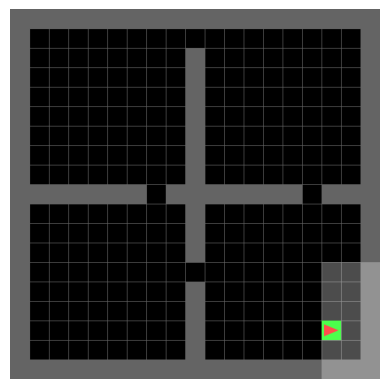

In [67]:
plt.imshow(env.get_frame())
plt.axis("off")